In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
from torch.utils.data import Dataset, DataLoader
import random

In [14]:
# -----------------------------------------------------
# 1. FUNCTIONS FOR CREATING SHAPES AND SDFs
# -----------------------------------------------------

def sdf_from_mask(mask):
    """Compute signed distance field from a binary mask."""
    dist_out = distance_transform_edt(mask == 0)
    dist_in = distance_transform_edt(mask == 1)
    sdf = dist_out - dist_in
    return sdf.astype(np.float32)


def create_random_shape(size=128):
    """
    Create a simple 2D shape: circle, square, diamond
    randomly for training the model.
    """
    img = np.zeros((size, size), dtype=np.uint8)
    cx, cy = size//2, size//2

    r = random.randint(20, 45)
    x = np.arange(size)
    y = np.arange(size)
    X, Y = np.meshgrid(x, y)

    shape_type = "circle"

    if shape_type == "circle":
        img[(X - cx)**2 + (Y - cy)**2 < r*r] = 1

    elif shape_type == "square":
        img[cy-r:cy+r, cx-r:cx+r] = 1

    elif shape_type == "diamond":
        img[np.abs(X - cx) + np.abs(Y - cy) < r] = 1

    return img


def create_slice(sdf):
    """Create a 1D cross-section slice from the SDF."""
    H, W = sdf.shape
    y_slice = random.randint(10, H-10)
    
    partial = np.zeros_like(sdf, dtype=np.float32)
    mask = np.zeros_like(sdf, dtype=np.float32)

    partial[y_slice, :] = sdf[y_slice, :]
    mask[y_slice, :] = 1.0
    return partial, mask

def create_slices(sdf, n_h=1, n_v=1, margin=10):
    """
    Create multiple horizontal and vertical slices from the SDF.

    Args:
        sdf (np.ndarray): 2D SDF array of shape (H, W).
        n_h (int): Number of horizontal slices.
        n_v (int): Number of vertical slices.
        margin (int): Margin from the border to avoid slices too close to edges.

    Returns:
        partial (np.ndarray): Partial SDF with values only on the selected slices.
        mask (np.ndarray): Binary mask indicating where the SDF is known (1) or unknown (0).
    """
    H, W = sdf.shape

    # Clamp the number of slices so we don't request more than possible
    max_h = max(0, H - 2 * margin)
    max_v = max(0, W - 2 * margin)

    n_h = min(n_h, max_h) if max_h > 0 else 0
    n_v = min(n_v, max_v) if max_v > 0 else 0

    partial = np.zeros_like(sdf, dtype=np.float32)
    mask = np.zeros_like(sdf, dtype=np.float32)

    # Choose unique horizontal indices
    if n_h > 0:
        y_candidates = list(range(margin, H - margin))
        y_slices = random.sample(y_candidates, n_h)
        for y in y_slices:
            partial[y, :] = sdf[y, :]
            mask[y, :] = 1.0

    # Choose unique vertical indices
    if n_v > 0:
        x_candidates = list(range(margin, W - margin))
        x_slices = random.sample(x_candidates, n_v)
        for x in x_slices:
            partial[:, x] = sdf[:, x]
            mask[:, x] = 1.0

    return partial, mask

In [21]:
# -----------------------------------------------------
# 2. DATASET
# -----------------------------------------------------

class SDFDataset(Dataset):
    def __init__(self, n_samples=500, size=128, n_h=2, n_v=2):
        self.data = []
        for _ in range(n_samples):
            mask = create_random_shape(size)
            sdf = sdf_from_mask(mask)
            partial, mask_s = create_slices(sdf, n_h=n_h, n_v=n_v)
            self.data.append((partial, mask_s, sdf))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        partial, mask_s, sdf = self.data[idx]
        # (C,H,W)
        return (
            torch.tensor(np.stack([partial, mask_s]), dtype=torch.float32),
            torch.tensor(sdf).unsqueeze(0)
        )

In [16]:
# -----------------------------------------------------
# 3. SMALL 2D UNET MODEL
# -----------------------------------------------------

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.net(x)


class UNetSmall(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = DoubleConv(2, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(32, 64)
        self.pool2 = nn.MaxPool2d(2)

        self.mid = DoubleConv(64, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv2 = DoubleConv(128, 64)

        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv1 = DoubleConv(64, 32)

        self.final = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(self.pool1(x1))
        x3 = self.mid(self.pool2(x2))

        x = self.up2(x3)
        x = self.conv2(torch.cat([x, x2], dim=1))

        x = self.up1(x)
        x = self.conv1(torch.cat([x, x1], dim=1))

        return self.final(x)

In [17]:

# -----------------------------------------------------
# 4. LOSSES (REC + EIKONAL + MASK)
# -----------------------------------------------------

def gradient_2d(x):
    """Finite differences gradient for eikonal."""
    dx = x[:, :, :, 1:] - x[:, :, :, :-1]
    dy = x[:, :, 1:, :] - x[:, :, :-1, :]
    return dx, dy

def loss_function(pred, gt, partial, mask, λ_eik=0.1, λ_mask=10):
    # Reconstruction loss
    L_rec = torch.mean(torch.abs(pred - gt))

    # Eikonal term
    dx, dy = gradient_2d(pred)

    # crop to same size
    dx = dx[:, :, :-1, :]     # shape (B,1,H-1,W)
    dy = dy[:, :, :, :-1]     # shape (B,1,H,W-1)

    grad_mag = torch.sqrt(dx**2 + dy**2 + 1e-6)
    L_eik = torch.mean(torch.abs(grad_mag - 1))

    # Mask loss
    L_mask = torch.mean(((pred - partial)**2) * mask)

    return L_rec + λ_eik * L_eik + λ_mask * L_mask


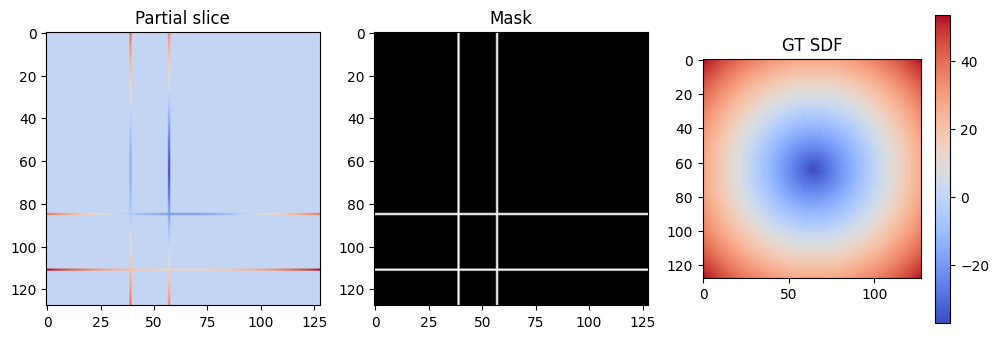

Training...
Epoch 1/10 - Loss: 22.5586
Epoch 2/10 - Loss: 19.0572
Epoch 3/10 - Loss: 7.5191
Epoch 4/10 - Loss: 7.7771
Epoch 5/10 - Loss: 5.6994
Epoch 6/10 - Loss: 6.7080
Epoch 7/10 - Loss: 5.6486
Epoch 8/10 - Loss: 5.8825
Epoch 9/10 - Loss: 5.3243
Epoch 10/10 - Loss: 4.8541


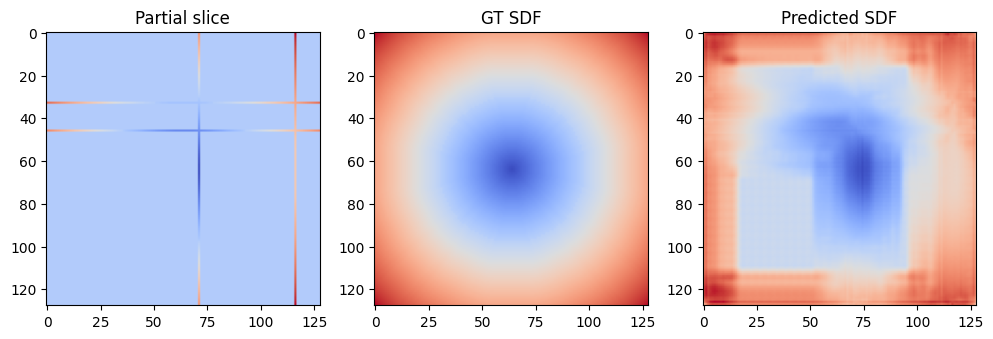

In [18]:
# -----------------------------------------------------
# 5. TRAINING + VISUALIZATION
# -----------------------------------------------------

dataset = SDFDataset(n_samples=300)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

model = UNetSmall()
opt = optim.Adam(model.parameters(), lr=1e-3)

# Visualize one example from dataset
partial, sdf_gt = dataset[0]
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Partial slice"); plt.imshow(partial[0], cmap='coolwarm')
plt.subplot(1,3,2); plt.title("Mask"); plt.imshow(partial[1], cmap='gray')
plt.subplot(1,3,3); plt.title("GT SDF"); plt.imshow(sdf_gt[0], cmap='coolwarm'); plt.colorbar()
plt.show()


print("Training...")
for epoch in range(10):
    for x, gt in loader:
        x, gt = x, gt
        pred = model(x)

        partial = x[:, 0:1]
        mask = x[:, 1:2]

        loss = loss_function(pred, gt, partial, mask)

        opt.zero_grad()
        loss.backward()
        opt.step()

    print(f"Epoch {epoch+1}/10 - Loss: {loss.item():.4f}")


# Visualize final prediction
x, gt = dataset[10]
x = x.unsqueeze(0)
pred = model(x).detach().cpu().numpy()[0,0]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Partial slice"); plt.imshow(x[0,0], cmap='coolwarm')
plt.subplot(1,3,2); plt.title("GT SDF"); plt.imshow(gt[0], cmap='coolwarm')
plt.subplot(1,3,3); plt.title("Predicted SDF"); plt.imshow(pred, cmap='coolwarm')
plt.show()


In [23]:
def laplacian_loss(pred):
    laplace = (
        -4 * pred +
        torch.roll(pred, 1, dims=2) +
        torch.roll(pred, -1, dims=2) +
        torch.roll(pred, 1, dims=3) +
        torch.roll(pred, -1, dims=3)
    )
    return torch.mean(laplace**2)

def curvature_loss(pred):
    dxx = pred[:, :, :, :-2] - 2*pred[:, :, :, 1:-1] + pred[:, :, :, 2:]
    dyy = pred[:, :, :-2, :] - 2*pred[:, :, 1:-1, :] + pred[:, :, 2:, :]
    return torch.mean(dxx**2) + torch.mean(dyy**2)

def loss_function(pred, gt, partial, mask, λ_eik=0.1, λ_mask=10, λ_smooth=0.05, λ_curv=0.05):

    # Reconstruction loss
    L_rec = torch.mean(torch.abs(pred - gt))

    # Eikonal loss
    dx, dy = gradient_2d(pred)
    dx = dx[:, :, :-1, :]
    dy = dy[:, :, :, :-1]
    grad_mag = torch.sqrt(dx**2 + dy**2 + 1e-6)
    L_eik = torch.mean(torch.abs(grad_mag - 1))

    # Mask consistency loss
    L_mask = torch.mean(((pred - partial)**2) * mask)

    # Smoothness: Laplacian loss
    laplace = laplacian_loss(pred)
    L_smooth = torch.mean(laplace**2)

    # Curvature (2nd derivative)
    L_curv = curvature_loss(pred)

    return (
        L_rec +
        λ_eik * L_eik +
        λ_mask * L_mask +
        λ_smooth * L_smooth +
        λ_curv * L_curv
    )


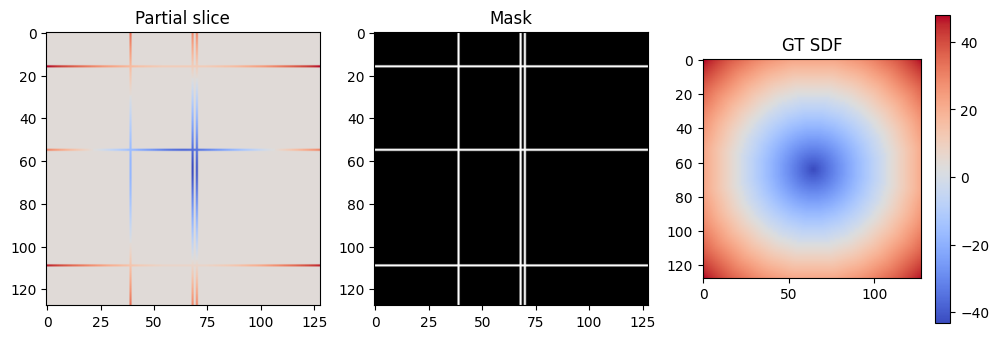

Training...
Epoch 1/10 - Loss: 28.5520
Epoch 2/10 - Loss: 11.4734
Epoch 3/10 - Loss: 6.9707
Epoch 4/10 - Loss: 7.6187
Epoch 5/10 - Loss: 4.7856
Epoch 6/10 - Loss: 5.8894
Epoch 7/10 - Loss: 4.8349
Epoch 8/10 - Loss: 3.8848
Epoch 9/10 - Loss: 5.0852
Epoch 10/10 - Loss: 4.4951


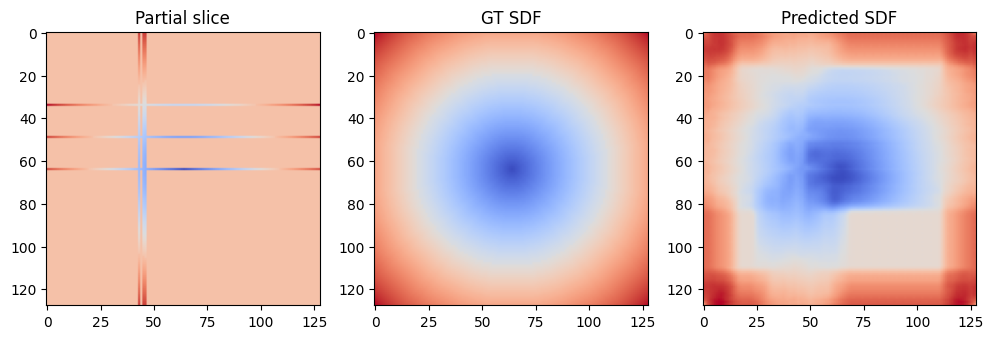

In [ ]:
dataset = SDFDataset(n_samples=300, n_h=3, n_v=3)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

model = UNetSmall()
opt = optim.Adam(model.parameters(), lr=1e-3)

# Visualize one example from dataset
partial, sdf_gt = dataset[0]
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Partial slice"); plt.imshow(partial[0], cmap='coolwarm')
plt.subplot(1,3,2); plt.title("Mask"); plt.imshow(partial[1], cmap='gray')
plt.subplot(1,3,3); plt.title("GT SDF"); plt.imshow(sdf_gt[0], cmap='coolwarm'); plt.colorbar()
plt.show()


print("Training...")
for epoch in range(10):
    for x, gt in loader:
        x, gt = x, gt
        pred = model(x)

        partial = x[:, 0:1]
        mask = x[:, 1:2]

        loss = loss_function(pred, gt, partial, mask)

        opt.zero_grad()
        loss.backward()
        opt.step()

    print(f"Epoch {epoch+1}/10 - Loss: {loss.item():.4f}")


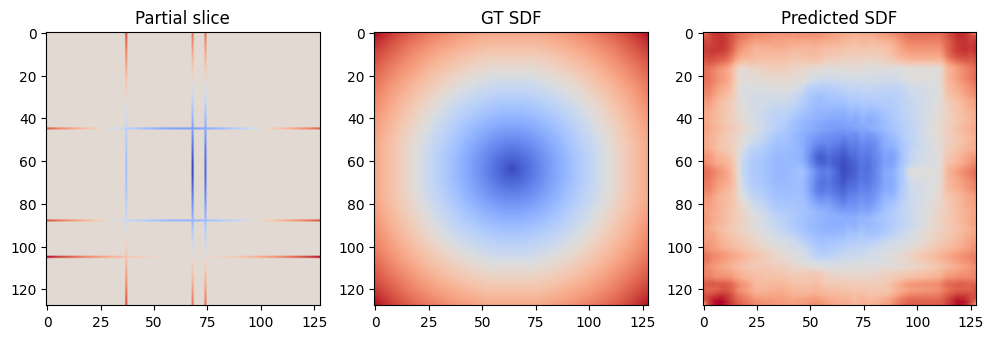

In [27]:
# Visualize final prediction
x, gt = dataset[11]
x = x.unsqueeze(0)
pred = model(x).detach().cpu().numpy()[0,0]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Partial slice"); plt.imshow(x[0,0], cmap='coolwarm')
plt.subplot(1,3,2); plt.title("GT SDF"); plt.imshow(gt[0], cmap='coolwarm')
plt.subplot(1,3,3); plt.title("Predicted SDF"); plt.imshow(pred, cmap='coolwarm')
plt.show()